In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import re
import numpy as np
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sns.set()
# Code for hiding seaborn warnings
warnings.filterwarnings("ignore")

In [61]:
df = pd.read_csv('training.csv',sep=',')
df.head()

,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


In [62]:
words_abs_freq = df.article_words.str.split(',',expand=True).stack().value_counts()

In [63]:
words_abs_freq_df = words_abs_freq.to_frame('count')

In [64]:
words_abs_freq_df['count'].value_counts()

1       13308
2        5402
3        2864
4        1927
5        1311
        ...  
881         1
945         1
1201        1
1297        1
1823        1
Name: count, Length: 860, dtype: int64

In [65]:
words_abs_freq_df.tail(400)

,count
centistok,1
primary278,1
canvad,1
multipurpos,1
gunrun,1
...,...
delmark,1
cherkaoui,1
pluspetrol,1
popularn,1


In [66]:
train_df = pd.read_csv('training.csv').set_index('article_number')
test_df = pd.read_csv('test.csv').set_index('article_number')

In [67]:
def MyTokenizer(words):
    return [word for word in words.split(',') if word.isalpha() and not bool(re.match(r'(\w)(\1{2,})',word)) and len(word) > 3]

In [68]:
le = LabelEncoder()
vectorizer = TfidfVectorizer(strip_accents='ascii',
                             tokenizer=MyTokenizer,
                             stop_words='english',
                             analyzer='word',
                             min_df=1,
                             max_df=1000,
                             max_features=5000,
                             ngram_range=(1,2))
x_train = vectorizer.fit_transform(train_df.iloc[:,0])
y_train = le.fit_transform(train_df.iloc[:,1])
x_test = vectorizer.transform(test_df.iloc[:,0])
y_test = le.transform(test_df.iloc[:,1])

In [69]:
sam = RandomOverSampler(sampling_strategy='all')
x_train,y_train = sam.fit_resample(x_train,y_train)

In [70]:
x_train.shape

(52074, 5000)

In [71]:
# k_best = SelectKBest(chi2, k=25000)
# x_train = k_best.fit_transform(x_train,y_train)
# x_test = k_best.transform(x_test)

In [72]:
x_train.shape

(52074, 5000)

In [73]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
sgd.fit(x_train,y_train)
y_pred = sgd.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.20      0.67      0.31         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.48      0.67      0.56        15
                         DEFENCE       0.60      0.92      0.73        13
                DOMESTIC MARKETS       0.15      1.00      0.27         2
                   FOREX MARKETS       0.52      0.81      0.63        48
                          HEALTH       0.61      0.79      0.69        14
                      IRRELEVANT       0.96      0.69      0.80       266
                   MONEY MARKETS       0.57      0.59      0.58        69
          SCIENCE AND TECHNOLOGY       0.25      0.33      0.29         3
                  SHARE LISTINGS       0.43      0.86      0.57         7
                          SPORTS       0.95      0.97      0.96        60

                        accuracy                           0.73       500
                       macro avg    

In [74]:
rfecv = RFECV(estimator=sgd, step=100, cv=StratifiedKFold(2),
              scoring='accuracy', n_jobs=-1, verbose=5)
rfecv.fit(x_train, y_train)

Fitting estimator with 5000 features.
Fitting estimator with 4900 features.
Fitting estimator with 4800 features.


RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                              penalty='l2', power_t=0.5, random_state=None,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=100,
      verbose=5)

Optimal number of features : 4700


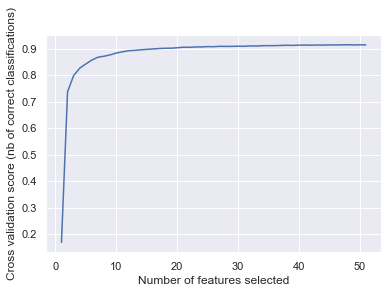

In [75]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [76]:
rfecv.support_

array([ True,  True,  True, ...,  True,  True,  True])

In [77]:
x_train_masked = x_train[:,rfecv.support_]
x_train_masked.shape

(52074, 4700)

In [78]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
sgd.fit(x_train_masked,y_train)
y_pred = sgd.predict(x_test[:,rfecv.support_])
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.20      0.67      0.31         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.48      0.67      0.56        15
                         DEFENCE       0.60      0.92      0.73        13
                DOMESTIC MARKETS       0.15      1.00      0.27         2
                   FOREX MARKETS       0.52      0.81      0.63        48
                          HEALTH       0.61      0.79      0.69        14
                      IRRELEVANT       0.96      0.69      0.80       266
                   MONEY MARKETS       0.57      0.59      0.58        69
          SCIENCE AND TECHNOLOGY       0.25      0.33      0.29         3
                  SHARE LISTINGS       0.43      0.86      0.57         7
                          SPORTS       0.95      0.97      0.96        60

                        accuracy                           0.73       500
                       macro avg    

In [79]:
rfecv.grid_scores_

array([0.16862542, 0.73745055, 0.7990936 , 0.82682337, 0.84285824,
       0.85760648, 0.86837961, 0.87204747, 0.8772324 , 0.88410723,
       0.88858163, 0.89276798, 0.89407382, 0.8962246 , 0.89797212,
       0.89946999, 0.90110228, 0.90215847, 0.9023505 , 0.9040404 ,
       0.90601836, 0.90582632, 0.90709375, 0.90720897, 0.90841879,
       0.90803472, 0.90941737, 0.90920613, 0.90930215, 0.90991666,
       0.90962861, 0.91101125, 0.91066559, 0.9118562 , 0.91208665,
       0.91197143, 0.91281638, 0.9135077 , 0.91310443, 0.91391097,
       0.91423743, 0.91375735, 0.91435265, 0.91416062, 0.91483274,
       0.9146407 , 0.91508238, 0.91542804, 0.9146407 , 0.9151592 ,
       0.91502477])

In [80]:
rfecv.estimator_.predict(x_test[:,rfecv.support_])
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.20      0.67      0.31         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.48      0.67      0.56        15
                         DEFENCE       0.60      0.92      0.73        13
                DOMESTIC MARKETS       0.15      1.00      0.27         2
                   FOREX MARKETS       0.52      0.81      0.63        48
                          HEALTH       0.61      0.79      0.69        14
                      IRRELEVANT       0.96      0.69      0.80       266
                   MONEY MARKETS       0.57      0.59      0.58        69
          SCIENCE AND TECHNOLOGY       0.25      0.33      0.29         3
                  SHARE LISTINGS       0.43      0.86      0.57         7
                          SPORTS       0.95      0.97      0.96        60

                        accuracy                           0.73       500
                       macro avg    

In [81]:
xgb = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=13, missing=np.nan, monotone_constraints=None,
              n_estimators=15, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=1337, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=1, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [82]:
xgb.fit(x_train,y_train)
y_pred = xgb.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.33      0.67      0.44         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.57      0.53      0.55        15
                         DEFENCE       0.48      0.92      0.63        13
                DOMESTIC MARKETS       0.14      1.00      0.25         2
                   FOREX MARKETS       0.44      0.58      0.50        48
                          HEALTH       0.61      0.79      0.69        14
                      IRRELEVANT       0.90      0.67      0.77       266
                   MONEY MARKETS       0.51      0.55      0.53        69
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         3
                  SHARE LISTINGS       0.38      0.86      0.52         7
                          SPORTS       0.88      1.00      0.94        60

                        accuracy                           0.69       500
                       macro avg    

In [84]:
x_test_proba = sgd.predict_proba(x_test[:,rfecv.support_])
x_test_proba.shape

(500, 11)

In [85]:
x_test_proba[0]

array([0.09721892, 0.02390807, 0.07663269, 0.2029402 , 0.03153802,
       0.01752974, 0.3110601 , 0.02286002, 0.01356222, 0.17972973,
       0.0230203 ])

In [86]:
sum(x_test_proba[0])

1.0

In [99]:
le = LabelEncoder()
vectorizer = TfidfVectorizer(strip_accents='ascii',
                             tokenizer=MyTokenizer,
                             stop_words='english',
                             analyzer='word',
                             ngram_range=(1,2))
x_train = vectorizer.fit_transform(train_df.iloc[:,0])
y_train = le.fit_transform(train_df.iloc[:,1])
x_test = vectorizer.transform(test_df.iloc[:,0])
y_test = le.transform(test_df.iloc[:,1])

In [100]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
clf = MultinomialNB()
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.00      0.00      0.00         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.00      0.00      0.00        15
                         DEFENCE       0.00      0.00      0.00        13
                DOMESTIC MARKETS       0.00      0.00      0.00         2
                   FOREX MARKETS       0.00      0.00      0.00        48
                          HEALTH       0.00      0.00      0.00        14
                      IRRELEVANT       0.62      0.98      0.76       266
                   MONEY MARKETS       0.50      0.33      0.40        69
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         3
                  SHARE LISTINGS       0.00      0.00      0.00         7
                          SPORTS       0.91      0.52      0.66        60

                        accuracy                           0.63       500
                       macro avg    

In [101]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
sgd.fit(x_train,y_train)
y_pred = sgd.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.00      0.00      0.00         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.00      0.00      0.00        15
                         DEFENCE       1.00      0.38      0.56        13
                DOMESTIC MARKETS       1.00      0.50      0.67         2
                   FOREX MARKETS       0.48      0.29      0.36        48
                          HEALTH       0.50      0.07      0.12        14
                      IRRELEVANT       0.78      0.94      0.85       266
                   MONEY MARKETS       0.54      0.64      0.59        69
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         3
                  SHARE LISTINGS       1.00      0.14      0.25         7
                          SPORTS       0.93      0.95      0.94        60

                        accuracy                           0.75       500
                       macro avg    